Total samples: 100
Training samples: 80
Testing samples: 20

--- Starting Grid Search Hyperparameter Tuning for MNB ---
Fitting 5 folds for each of 16 candidates, totalling 80 fits

     Multinomial Naïve Bayes Optimization Results
Best Cross-Validation Accuracy: 0.8000
Best Parameters Found:
  mnb__alpha: 0.1
  tfidf__max_features: 3000
  tfidf__ngram_range: (1, 2)

Final Test Set Accuracy: 0.9000

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       1.00      0.78      0.88         9
           1       0.85      1.00      0.92        11

    accuracy                           0.90        20
   macro avg       0.92      0.89      0.90        20
weighted avg       0.92      0.90      0.90        20


--- Generating Visualizations ---


/tmp/ipython-input-178179278.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='plasma')


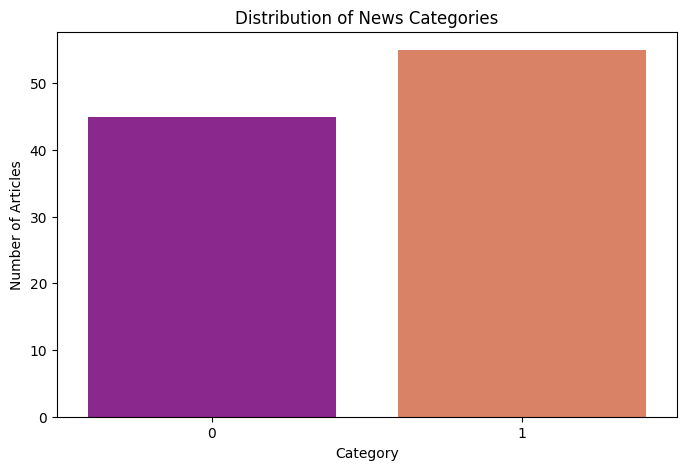

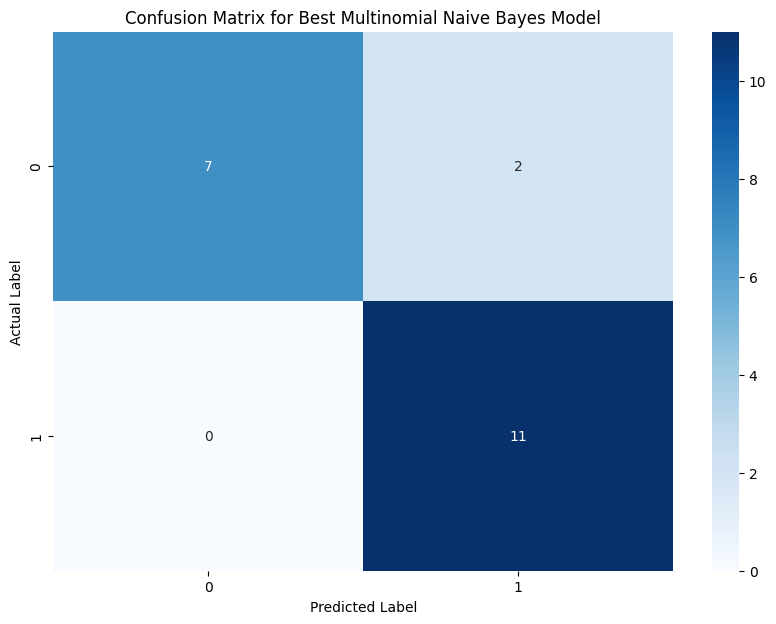

/tmp/ipython-input-178179278.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_probs, y=top_features, ax=ax, palette='coolwarm')
/tmp/ipython-input-178179278.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_probs, y=top_features, ax=ax, palette='coolwarm')


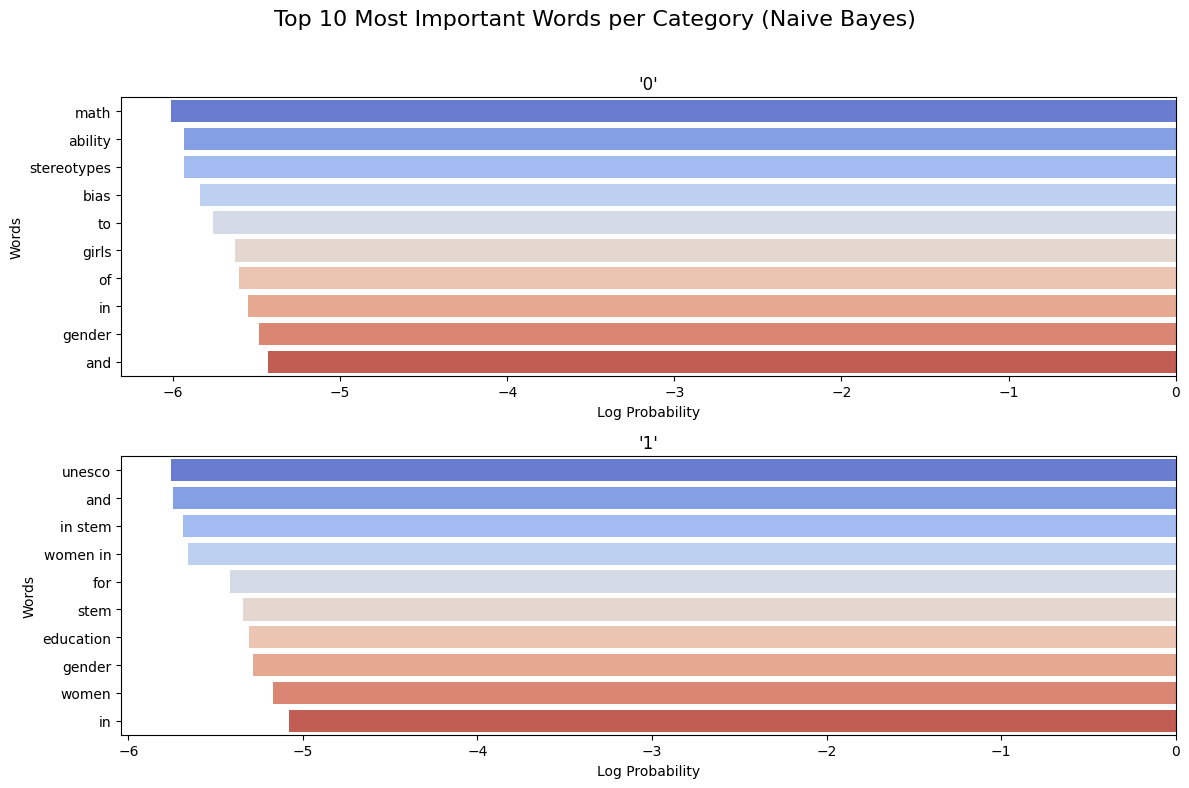

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

# --- 1. Data Loading and Preparation ---

# Load the dataset (ensure 'Dataset100.csv' is uploaded to your Colab environment)
df = pd.read_csv("Dataset100.csv")

# Combine 'title' and 'summary' into a single, rich text feature
df['full_text'] = df['title'] + " " + df['summary']

# Define features (X) and labels (y)
X = df['full_text']
y = df['label']

# Split data into training and testing sets (80% train, 20% test)
# Stratify ensures the label distribution is maintained in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Total samples: {len(X)}")
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")
print("\n--- Starting Grid Search Hyperparameter Tuning for MNB ---")

# --- 2. Build the Pipeline and Parameter Grid ---

# Create a pipeline: TF-IDF Vectorizer -> Multinomial Naive Bayes
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

# Define the parameter grid to search for the best combination:
param_grid = {
    # TF-IDF Vectorization Optimization:
    'tfidf__ngram_range': [(1, 1), (1, 2)],  # Test unigrams (1,1) and unigrams+bigrams (1,2)
    'tfidf__max_features': [3000, 5000],     # Limit number of features

    # MultinomialNB Hyperparameter Tuning:
    'mnb__alpha': [0.1, 0.5, 1.0, 2.0], # Alpha is the smoothing parameter (Laplace smoothing).
                                          # Values closer to 0 reduce smoothing,
                                          # higher values increase smoothing to prevent zero probabilities.
}

# --- 3. Execute Grid Search Cross-Validation ---

# GridSearchCV searches all combinations of parameters using 5-fold cross-validation
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,                 # 5-fold cross-validation
    scoring='accuracy',   # Optimize for accuracy
    verbose=1,
    n_jobs=-1             # Use all available cores
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# --- 4. Evaluation and Results ---

# Get the best model from the search
best_model = grid_search.best_estimator_

print("\n" + "="*50)
print("     Multinomial Naïve Bayes Optimization Results")
print("="*50)
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")
print("Best Parameters Found:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")
print("="*50)

# Evaluate the best model on the unseen test set
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"\nFinal Test Set Accuracy: {test_accuracy:.4f}")
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred, zero_division=0))

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# ==============================================================================
# 5. Visualize the Results
# ==============================================================================

# Graph 1: Show the distribution of the labels in the entire dataset
print("\n--- Generating Visualizations ---")
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=df, palette='plasma')
plt.title('Distribution of News Categories')
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.show()

# Graph 2: Create a confusion matrix for the best model
cm = confusion_matrix(y_test, y_pred)
class_names = best_model.classes_

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for Best Multinomial Naive Bayes Model')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Graph 3: Display the most important features (words) for each category

# Get feature names from the TF-IDF vectorizer in the best pipeline
feature_names = best_model.named_steps['tfidf'].get_feature_names_out()

# Get the log probabilities from the MultinomialNB model
# The shape is (n_classes, n_features)
log_probabilities = best_model.named_steps['mnb'].feature_log_prob_

# Plot the top 10 features for each class
plt.figure(figsize=(12, len(class_names) * 4))
plt.suptitle('Top 10 Most Important Words per Category (Naive Bayes)', fontsize=16)

for i, category in enumerate(class_names):
    # Get the indices of the top 10 features for this category
    top_10_indices = np.argsort(log_probabilities[i])[-10:]

    # Get the corresponding feature names and their log probabilities
    top_features = feature_names[top_10_indices]
    top_probs = log_probabilities[i][top_10_indices]

    ax = plt.subplot(len(class_names), 1, i + 1)
    sns.barplot(x=top_probs, y=top_features, ax=ax, palette='coolwarm')
    ax.set_title(f"'{category}'")
    ax.set_xlabel('Log Probability')
    ax.set_ylabel('Words')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()